In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pystan


In [2]:
from cache_utils import StanModel_cache_file

In [3]:
# r_i \succ c_i
preferences = [
    (0.2, 0.1), 
    (0.35, 0.5),
    (0.2, 0.35),
    (0.2, 0.6),
    (0.8, 0.7)
]

x_unique = list(set(sum(preferences, tuple())))
x_unique.sort()

rd = {v:idx for idx, v in enumerate(x_unique)}

succ_list = []
for left, right in preferences:
    succ_list.append([rd[left], rd[right]])

succ_arr = np.array(succ_list) + 1 # index start from 1
x_arr = np.array(x_unique)

In [4]:
alpha = 0.1
rho = 0.1
sigma = 0.001

model_dat = dict(
    N = x_arr.shape[0],
    M = succ_arr.shape[0],
    x = x_arr,
    succ_list = succ_arr,
    
    alpha = alpha,
    rho = rho,
    sigma = sigma
)


In [5]:
sm = StanModel_cache_file('model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_07bc5feacff32720f11c46d33726876d NOW.


In [6]:
fit = sm.sampling(data=model_dat, iter=2000, chains=1, control = {"max_treedepth": 15})


In [7]:
la = fit.extract(permuted=True)  # return a dictionary of arrays


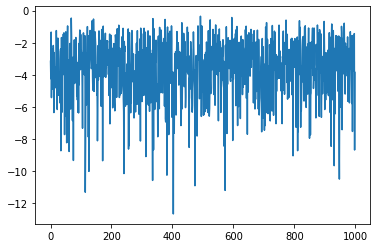

In [8]:
plt.plot(la['lp__'])

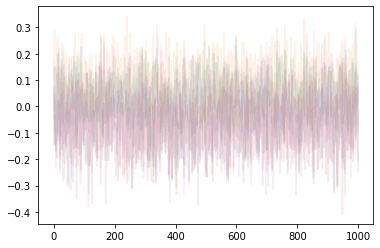

In [9]:
plt.plot(la['y'], alpha=0.1)

In [10]:
np.mean(la['y'],0),np.std(la['y'],0)

(array([ 0.02796785,  0.10911268,  0.0216589 , -0.07388782, -0.08686576,
        -0.05819884,  0.01441915]),
 array([0.08088451, 0.07655156, 0.07729695, 0.08777299, 0.08772132,
        0.09895816, 0.09181531]))

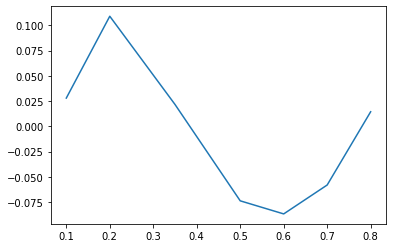

In [11]:
plt.plot(x_arr, np.mean(la['y'],0))

In [12]:
def cov_exp_quad(x, y=None,*, alpha, rho):
    if y is None:
        y = x
    mat = (x[:,np.newaxis] - y[np.newaxis])**2
    k = alpha**2 * np.exp(-mat /2 /(rho**2))
    return k

In [13]:
K = cov_exp_quad(x_arr, alpha = alpha, rho=rho) + np.eye(x_arr.shape[0]) * 1e-6

In [14]:
inv_K = np.linalg.inv(K)

In [15]:
xx = np.linspace(0,1,50)
K12 = cov_exp_quad(xx, x_arr, alpha = alpha, rho=rho)

mu_mat = K12 @ inv_K @ la['y'].T

In [16]:
mu_mat.shape

(50, 1000)

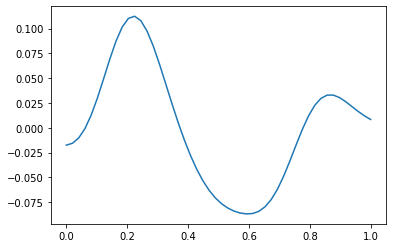

In [17]:
plt.plot(xx, mu_mat.mean(-1))

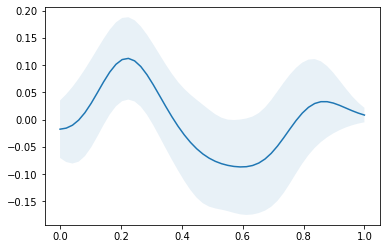

In [18]:
plt.plot(xx, mu_mat.mean(-1))
plt.fill_between(xx, mu_mat.mean(-1) - mu_mat.std(-1), mu_mat.mean(-1) + mu_mat.std(-1), alpha=0.1)

In [19]:
K21 = K12.T
K11 = cov_exp_quad(xx, alpha = alpha, rho=rho)
sigma_bar = K11 - K12 @ inv_K @ K21

In [20]:
center = mu_mat.mean(-1)
r = np.sqrt(np.diagonal(sigma_bar))

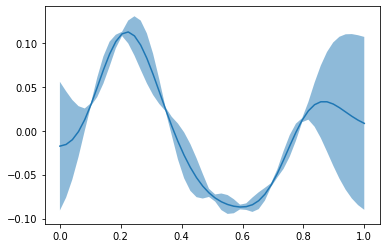

In [21]:
plt.plot(xx, center)
plt.fill_between(xx, center - r, center + r, alpha=0.5)

The confidence-bar used above have some ambiguities. In fact, we want 
$$
p(f|D) = \int p(f|w,D)p(w|D) dw \approx \sum_i p(f|w_i,D) p(w_i|D) = \frac{1}{m} \sum_i p(f|w_i,D)
$$

$m$ is sample size drawn from posterior $p(w_i|D)$. Considering $p(f|w_i)$ is a multivariate normal distribution,
we get a mixture gaussian distribution. This likn give a mean and covariance of the mixture distribution:

https://math.stackexchange.com/questions/195911/calculation-of-the-covariance-of-gaussian-mixtures?newreg=a9d5103af3a94c9cb1d3738da5a1f318

Briefly, let $p(f|w_i) \sim N(\mu_i, C_i)$

$$
\bar{\mu} = \frac{1}{M} \sum_{i} \mu_i 
$$

$$
\bar{C} = \frac{1}{M} \sum_{i} C_i + \frac{1}{M} \sum_{i} (\mu_i - \bar{\mu}) (\mu_i - \bar{\mu})^T
$$

Notice the mixture distribution itself is not a multivariate gaussian generally. 

In [22]:
mu_mat.shape

(50, 1000)

In [23]:
mu_bar = mu_mat.mean(-1)

mu_mat_centered = mu_mat - mu_bar[:,np.newaxis]
mu_mat_centered.shape

(50, 1000)

In [24]:
C_extra = (mu_mat_centered[:,np.newaxis] * mu_mat_centered[np.newaxis]).mean(-1)

In [25]:
C_bar = sigma_bar + C_extra

In [26]:
np.linalg.norm(sigma_bar), np.linalg.norm(C_bar)

(0.049736561718519624, 0.174710414295642)

In [27]:
center = mu_mat.mean(-1)
r = np.sqrt(np.diagonal(C_bar))

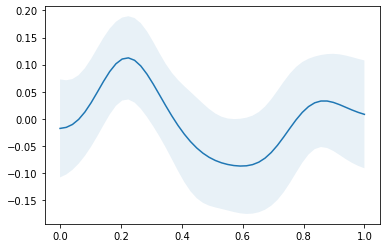

In [28]:
plt.plot(xx, center)
plt.fill_between(xx, center - r, center + r, alpha=0.1)

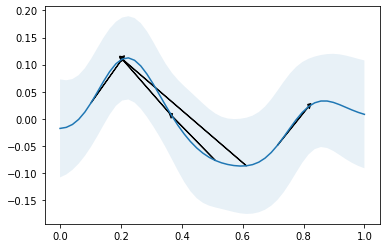

In [30]:
plt.plot(xx, center)
plt.fill_between(xx, center - r, center + r, alpha=0.1)

for left,right in np.round(np.array(preferences)*xx.shape[0]):
    left = int(left)
    right = int(right)
    
    ax = xx[right]
    ay = center[right]
    bx = xx[left]
    by = center[left]
    dx = bx - ax
    dy = by - ay
    
    plt.arrow(ax,ay,dx,dy, head_width=0.01, head_length=0.01, fc='k', ec='k')
    
plt.savefig("example.svg")